##  Step 1: Load the Twitter Sentiment Dataset

We begin by importing essential libraries (`pandas`, `numpy`, `matplotlib`, `seaborn`) and reading the dataset using `pandas.read_csv()`.

The dataset file is encoded in `ISO-8859-1` instead of UTF-8, so we explicitly set the correct encoding.


In [31]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


import spacy

from tqdm import tqdm

In [3]:
df = pd.read_csv("D:\\sentiment_analysis_project\\notebook\\data\\data.csv", encoding='ISO-8859-1')


In [4]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew



## 📄 Dataset Column Description

This dataset contains 1.6 million labeled tweets for sentiment analysis. The columns are:

- **target**: Sentiment label (0 = negative, 4 = positive)
- **ids**: Unique tweet ID
- **date**: Date and time of the tweet
- **flag**: Query term (always "NO_QUERY" in this dataset)
- **user**: Twitter username of the author
- **text**: The tweet content (used as input for NLP)

In most cases, we only use the `target` and `text` columns for model training.


In [5]:
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [6]:
df = pd.read_csv("D:\\sentiment_analysis_project\\notebook\\data\\data.csv",names=column_names, encoding='ISO-8859-1')


In [7]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 🧹 Step 2: Basic Exploratory Data Analysis (EDA)

Before preprocessing or model training, we perform quick sanity checks on the dataset:

In [8]:
df.shape

(1600000, 6)

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

## ✅ EDA Summary & Insights

- The dataset contains **1.6 million tweets** with 6 columns.
- There are **no duplicate rows** and **no missing values**, which means the dataset is clean structurally.
- The `flag` column has no variability (always "NO_QUERY") and can be dropped.
- For sentiment analysis, we only need:
  - `target` → the sentiment label (0 = negative, 4 = positive)
  - `text` → the tweet content

## 🔎 Step 3: Dataset Info and Redundancy Check

We now inspect the structure and contents of the dataset using:
This helps us identify which columns are relevant for sentiment classification and which can be dropped.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [12]:
df['flag'].value_counts()


flag
NO_QUERY    1600000
Name: count, dtype: int64

In [13]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

### Tweet Length Statistics

Now that we've inspected the distribution of our target labels, let's explore the distribution of tweet lengths.  
Measuring tweet length can give us insight into text complexity, common patterns, and whether preprocessing steps like trimming or padding might be needed later in modeling.


In [14]:
df['text'].apply(len).describe()  # Tweet length stats


count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: text, dtype: float64

**Observations:**

- **Count**: We have 1.6 million tweets in total.
- **Average length**: About 75 characters per tweet.
- **Shortest tweet**: 6 characters.
- **Longest tweet**: 374 characters.
- **Spread**: Most tweets are between 44 and 104 characters (25th–75th percentile).

These insights help us decide if we need special handling for extremely short or long tweets during preprocessing.


### Sentiment Distribution

Next, let's visualize the distribution of sentiment labels in our dataset.  
This will help us check for **class imbalance**, which is crucial for understanding whether our model might be biased toward a particular sentiment.


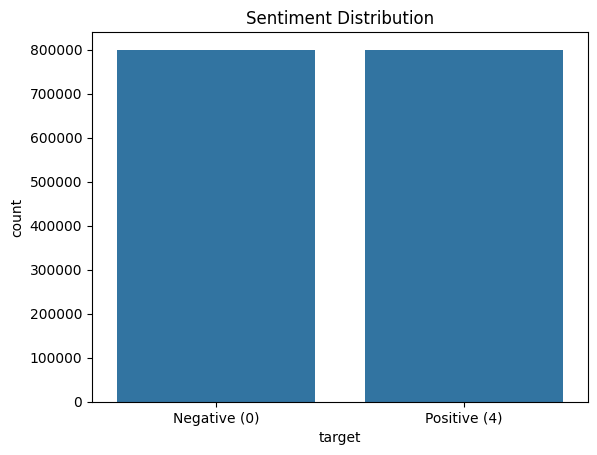

In [15]:


sns.countplot(x='target', data=df)
plt.xticks([0, 1], ['Negative (0)', 'Positive (4)'])  # adjust if you've mapped target to sentiment
plt.title("Sentiment Distribution")
plt.show()


**Observations:**

- The dataset contains two classes: **Negative (0)** and **Positive (4)**.
- The distribution appears to be nearly balanced, with roughly equal counts for both classes.
- This balance means we likely **won’t need heavy resampling** techniques before training.


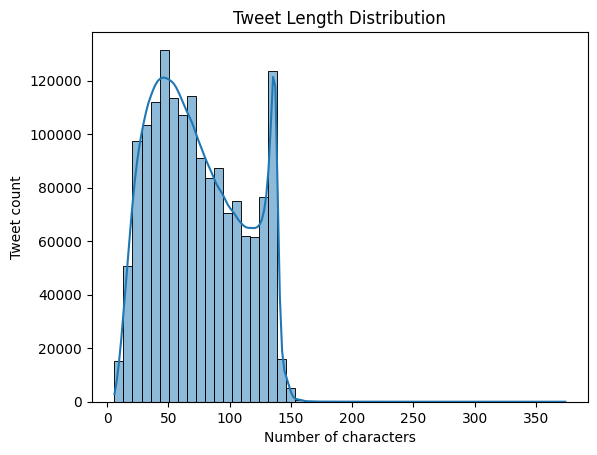

In [16]:
df['text_length'] = df['text'].apply(len)

sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of characters")
plt.ylabel("Tweet count")
plt.show()


In [17]:
df.replace({'target':{4:1}},inplace=True)

In [18]:
df['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [25]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [21]:
import re

In [20]:
from nltk.stem import PorterStemmer

port_stem = PorterStemmer()


In [ ]:
def streming(content):
    stemed_content=re.sub('[^a-zA-Z]',' ',content)
    stemed_content=stemed_content.lower()
    stemed_content=stemed_content.split()
    stemed_content=[port_stem.stem(word) for word in stemed_content if not word in stopwords.words('english')]
    stemed_content=''.join(stemed_content)
    return stemed_content

In [28]:
from tqdm import tqdm
tqdm.pandas()


In [32]:


# 1) Load spaCy small English model, disable slow components
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])
# If you see warnings about lookups, it's fine for this use.

# 2) Precompile regex and build a generator to keep memory low
NON_ALPHA = re.compile(r"[^a-zA-Z]+")

def cleaned_texts(series):
    # yields cleaned strings one by one (saves memory)
    for s in series.astype(str):
        yield NON_ALPHA.sub(" ", s).lower().strip()

# 3) Stream through spaCy using all CPU cores with batching
texts = cleaned_texts(df["text"])
docs = nlp.pipe(texts, n_process=-1, batch_size=5000)

def to_lemmas(doc):
    # keep alphabetic tokens that are not stopwords; lemmatize
    return " ".join(t.lemma_ for t in doc if t.is_alpha and not t.is_stop)

lemmas = []
for doc in tqdm(docs, total=len(df)):   # progress bar for the whole 1.6M
    lemmas.append(to_lemmas(doc))

df["lemma"] = lemmas


100%|██████████| 1600000/1600000 [58:16<00:00, 457.55it/s] 


In [34]:
# Or CSV (larger + slower to load)
df.to_csv("processed_tweets.csv", index=False, encoding="utf-8")